# Setup 

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger
import matplotlib.pyplot as plt
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [2]:
if tf.test.gpu_device_name(): 
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Default GPU Device:/device:GPU:0


In [3]:
tf.version.VERSION

'2.4.1'

In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
def plot_data(x_train, y_train):
    # Plot first 10 data in training set
    fig, axes = plt.subplots(2, 5, figsize=(15,5))
    for i in range(2):
        for j in range(5):
            axes[i, j].set_title("Label = {}".format(y_train[i*5+j]))
            axes[i, j].axis("off")
            axes[i, j].imshow(x_train[i*5+j].reshape(28, 28), cmap=None)
    plt.show()

In [6]:
def build_model(arg):
    if arg == 'NN':
        print('Using NN Sequential Model')
        # Prepare parameters
        num_classes = 10
        input_shape = (28, 28, 1)
        model = keras.Sequential(
            [
                keras.Input(shape=input_shape),
                layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
                layers.MaxPooling2D(pool_size=(2, 2)),
                layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
                layers.MaxPooling2D(pool_size=(2, 2)),
                layers.Flatten(),
                layers.Dropout(0.5),
                layers.Dense(num_classes, activation="softmax"),
            ]
        )
        model.summary()
        model.compile(loss='categorical_crossentropy',
                      optimizer=RMSprop(),
                      metrics=['accuracy'])
    elif arg == 'RandomForest':
        print('Using RandomForest Model')
        model = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=10)
    return model

In [7]:
def train_with_data(arg, model, x_train, y_train):
    if arg == 'NN':
        print('Training with NN Sequential Model')
        num_classes = 10
        # Make sure images have shape (28, 28, 1)
        x_train = np.expand_dims(x_train, -1)
        # convert class vectors to binary class matrices
        y_train = keras.utils.to_categorical(y_train, num_classes)
        
        es = EarlyStopping(monitor='val_loss', patience=2)
        csv_logger = CSVLogger('training.log')
        # Prepare parameter
        batch_size = 128
        epochs = 20

        # Fit the data
        hist = model.fit(x_train, y_train,
                         batch_size=batch_size,
                         epochs=epochs,
                         verbose=1,
                         validation_split=0.1,
                         callbacks=[es, csv_logger])
        
        loss = hist.history['loss']
        val_loss = hist.history['val_loss']
        epochs = len(loss)
        plt.plot(range(epochs), loss, marker='.', label='loss(training data)')
        plt.plot(range(epochs), val_loss, marker='.', label='val_loss(evaluationdata)')
        plt.legend(loc='best')
        plt.grid()
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.show()
        
    elif arg == 'RandomForest':
        print('Training with RandomForest Model')
        x_train = x_train.reshape(-1, 28*28)
#         print(x_train.shape)
        model.fit(x_train, y_train)

In [8]:
def evaluate_with_data(arg, model, x_test, y_test):
    if arg == 'NN':
        print('Evaluating with NN Sequential Model')
        num_classes = 10
        x_test = np.expand_dims(x_test, -1)
        y_test = keras.utils.to_categorical(y_test, num_classes)
        score = model.evaluate(x_test, y_test, verbose=0)
        print('Test loss:', score[0])
        print('Test acc:', score[1])
    elif arg == 'RandomForest':
        print('Evaluating with RandomForest Model')
        x_test = x_test.reshape(-1, 28*28)
        y_pred = model.predict(x_test)
        print("Test acc: {0:.3f}%".format(accuracy_score(y_test, y_pred) * 100))

x_train shape: (60000, 28, 28)
y_train shape: (60000,)


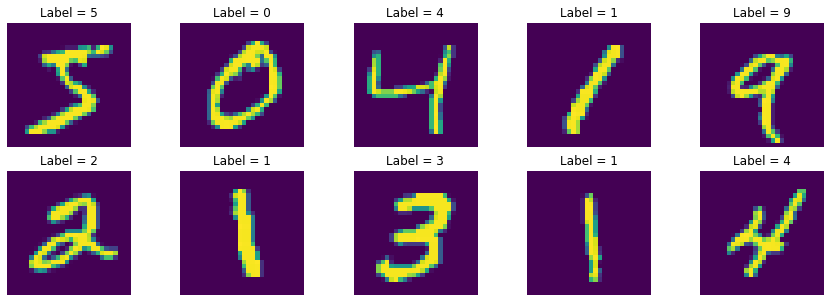

Using RandomForest Model
Training with RandomForest Model
Evaluating with RandomForest Model
Test acc: 94.800%


In [9]:
if __name__ == '__main__':
   
    # Split data between train and test sets
    # Check if MNIST dataset exists or not (download MNIST and save at path relative to ~/.keras/datasets).
    (x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data(path="mnist.npz")

    # Scale images to the [0, 1] range
    x_train = x_train.astype("float32") / 255
    x_test = x_test.astype("float32") / 255

    print("x_train shape:", x_train.shape)
    print("y_train shape:", y_train.shape)
    
    plot_data(x_train, y_train)

    model_name = 'RandomForest'
    
    model = build_model(model_name)
    
    train_with_data(model_name, model, x_train, y_train)
    
    evaluate_with_data(model_name, model, x_test, y_test)